# **0.0 DATA PROCESSING**

In [104]:
!git clone https://github.com/edwinkmusaasizi/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 53 (delta 18), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 445.02 KiB | 3.53 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [105]:
%cd Machine-Learning
%cd data
%cd interim
!ls

/content/Machine-Learning/data/interim/Machine-Learning/data/interim/Machine-Learning
/content/Machine-Learning/data/interim/Machine-Learning/data/interim/Machine-Learning/data
/content/Machine-Learning/data/interim/Machine-Learning/data/interim/Machine-Learning/data/interim
cleaned_mental_health_data.csv


0.1 Data Processing

In [106]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load data
df = pd.read_csv("cleaned_mental_health_data.csv")

# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]

df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Identify all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns to encode:", categorical_cols)

# Encode all categorical features
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and labels
X = df.drop(columns="adherence").values
y = df["adherence"].values

# Split data into train, validation, test (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE to only the training set
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
from collections import Counter
print("New class distribution:", Counter(y_train_resampled))

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Categorical columns to encode: Index(['sex', 'Religion', 'marital status', 'education status', 'residence',
       'substance use', 'comorbidity',
       'It is unnatural for my mind and body to be controlled by medication?',
       'My thoughts are clearer on medication',
       'By staying on medication, I can prevent getting sick',
       'I feel weird, like a ‘zombie’ on medication',
       'Medication makes me feel tired and sluggish',
       'Some of your symptoms are made by your mind.', 'You are mentally well',
       'You do not need medication', 'Your stay in the hospital is necessary',
       'The doctor is right in prescribing medication for you.',
       'You do not need to be seen by a doctor or psychiatrist',
       'If someone said you have a nervous or mental illness, they would be right',
       'None of the unusual things you are experiencing are due to an illness.',
       '. Loss of energy or drive', 'Feeling unmotivated or numb',
       'Daytime sedation or drowsi

In [107]:
# Check class distribution in the training set
class_distribution = np.bincount(y_train)
print("Class Distribution in Training Set:")
print(f"Class 0 (Non-Adherent): {class_distribution[0]}")
print(f"Class 1 (Adherent): {class_distribution[1]}")

Class Distribution in Training Set:
Class 0 (Non-Adherent): 55
Class 1 (Adherent): 26


Implement class weight

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Example model (Assuming a simple neural network)
class AdherenceModel(nn.Module):
    def __init__(self, input_size):
        super(AdherenceModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 2)  # Output has 2 classes (0 and 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)  # No softmax needed for CrossEntropyLoss
        return x

# Initialize model
input_size = X_train.shape[1]  # Number of features
model = AdherenceModel(input_size)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
for epoch in range(10):  # Adjust epochs as needed
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        batch_y = batch_y.long()  # Convert to long for CrossEntropyLoss
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")



Epoch 1, Loss: 0.7398043870925903
Epoch 2, Loss: 0.6390100717544556
Epoch 3, Loss: 0.6645118594169617
Epoch 4, Loss: 0.6223667860031128
Epoch 5, Loss: 0.5667624473571777
Epoch 6, Loss: 0.5892457365989685
Epoch 7, Loss: 0.542084813117981
Epoch 8, Loss: 0.5019883513450623
Epoch 9, Loss: 0.44666144251823425
Epoch 10, Loss: 0.4940347969532013


# MODEL 1: DNN

## **1.0 Teacher Model(DNN)**

1.1  Define the Teacher Model Architecture



In [76]:
import torch.nn as nn

class TeacherModel(nn.Module):
    def __init__(self, input_dim):
        super(TeacherModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = X_train.shape[1]
teacher = TeacherModel(input_dim)

1.2 Training Loop

In [77]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.001)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
counter = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    teacher.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    teacher.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = teacher(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_auc = roc_auc_score(val_true, val_preds)
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_acc = accuracy_score(val_true, val_preds_binary)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(teacher.state_dict(), "best_teacher.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

Epoch 1/100
Train Loss: 0.7056 | Val Loss: 0.6902 | Val AUC: 0.5972 | Val Acc: 0.5556
Epoch 2/100
Train Loss: 0.6860 | Val Loss: 0.6715 | Val AUC: 0.6806 | Val Acc: 0.6667
Epoch 3/100
Train Loss: 0.6617 | Val Loss: 0.6473 | Val AUC: 0.7361 | Val Acc: 0.6667
Epoch 4/100
Train Loss: 0.6270 | Val Loss: 0.6243 | Val AUC: 0.7222 | Val Acc: 0.6667
Epoch 5/100
Train Loss: 0.5949 | Val Loss: 0.6026 | Val AUC: 0.7083 | Val Acc: 0.6667
Epoch 6/100
Train Loss: 0.5845 | Val Loss: 0.5887 | Val AUC: 0.7083 | Val Acc: 0.6667
Epoch 7/100
Train Loss: 0.5534 | Val Loss: 0.5838 | Val AUC: 0.7083 | Val Acc: 0.6667
Epoch 8/100
Train Loss: 0.5440 | Val Loss: 0.5893 | Val AUC: 0.7222 | Val Acc: 0.6667
Epoch 9/100
Train Loss: 0.5314 | Val Loss: 0.5998 | Val AUC: 0.7222 | Val Acc: 0.6667
Epoch 10/100
Train Loss: 0.5234 | Val Loss: 0.6085 | Val AUC: 0.7222 | Val Acc: 0.6667
Epoch 11/100
Train Loss: 0.4944 | Val Loss: 0.6004 | Val AUC: 0.7222 | Val Acc: 0.6667
Epoch 12/100
Train Loss: 0.4584 | Val Loss: 0.5930 |

1.3 Evaluation

In [78]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    """Calculate specificity (true negative rate)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    teacher.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    teacher.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = teacher(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Convert predictions to binary (0 or 1)
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)

    # Calculate precision, recall, F1-score, specificity, and AUC
    val_precision = precision_score(val_true, val_preds_binary)
    val_recall = recall_score(val_true, val_preds_binary)
    val_f1 = f1_score(val_true, val_preds_binary)
    val_specificity = calculate_specificity(val_true, val_preds_binary)
    val_auc = roc_auc_score(val_true, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")
    print(f"Val F1-Score: {val_f1:.4f} | Val Specificity: {val_specificity:.4f}")
    print(f"Val AUC: {val_auc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(teacher.state_dict(), "best_teacher.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

Epoch 1/100
Train Loss: 0.4705 | Val Loss: 0.5833
Val Precision: 0.0000 | Val Recall: 0.0000
Val F1-Score: 0.0000 | Val Specificity: 1.0000
Val AUC: 0.7361
Epoch 2/100
Train Loss: 0.4363 | Val Loss: 0.5844
Val Precision: 0.0000 | Val Recall: 0.0000
Val F1-Score: 0.0000 | Val Specificity: 1.0000
Val AUC: 0.7361
Epoch 3/100
Train Loss: 0.4078 | Val Loss: 0.5961
Val Precision: 1.0000 | Val Recall: 0.1667
Val F1-Score: 0.2857 | Val Specificity: 1.0000
Val AUC: 0.7500
Epoch 4/100
Train Loss: 0.3858 | Val Loss: 0.6202
Val Precision: 1.0000 | Val Recall: 0.1667
Val F1-Score: 0.2857 | Val Specificity: 1.0000
Val AUC: 0.7500
Epoch 5/100
Train Loss: 0.3521 | Val Loss: 0.6489
Val Precision: 1.0000 | Val Recall: 0.1667
Val F1-Score: 0.2857 | Val Specificity: 1.0000
Val AUC: 0.7639
Epoch 6/100
Train Loss: 0.3373 | Val Loss: 0.6927
Val Precision: 1.0000 | Val Recall: 0.1667
Val F1-Score: 0.2857 | Val Specificity: 1.0000
Val AUC: 0.7639
Early stopping!
Learning Rate: 0.001


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1.4 Test Evaluation

In [79]:
# Load the best saved model
teacher.load_state_dict(torch.load("best_teacher.pth"))

# Test evaluation
teacher.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = teacher(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.3).astype(int) #lowered the threshold from 0.5 to 0.3

# Calculate metrics
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_specificity = calculate_specificity(test_true, test_preds_binary)
test_auc = roc_auc_score(test_true, test_preds)

print("Test Metrics:")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test Specificity: {test_specificity:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test Metrics:
Test Precision: 0.2000 | Test Recall: 0.1667
Test F1-Score: 0.1818 | Test Specificity: 0.6667
Test AUC: 0.4306


<ipython-input-79-95e920c83986>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher.pth"))


## **2.0 Contrastive Learning**

---



2.1 Data Preparation for Contrastive Learning

We need to create pairs of samples for contrastive learning. Each pair consists of:

Two samples from the same class (positive pair).

Two samples from different classes (negative pair).

In [80]:
import torch
from torch.utils.data import Dataset, DataLoader

class ContrastiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x1 = self.X[idx]
        y1 = self.y[idx]

        # Randomly select a positive or negative pair
        if torch.rand(1) > 0.5:
            # Positive pair: same class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] != y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 1  # Positive pair label
        else:
            # Negative pair: different class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] == y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 0  # Negative pair label

        x2 = self.X[idx2]
        return x1, x2, label

# Create contrastive datasets
train_contrastive_dataset = ContrastiveDataset(X_train, y_train)
val_contrastive_dataset = ContrastiveDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32
train_contrastive_loader = DataLoader(train_contrastive_dataset, batch_size=batch_size, shuffle=True)
val_contrastive_loader = DataLoader(val_contrastive_dataset, batch_size=batch_size)

23.2 Define the Contrastive Loss

We’ll use the NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which is commonly used in contrastive learning.

In [81]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, labels):
        # Normalize the embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Positive pairs are on the diagonal
        pos_pairs = torch.diag(sim_matrix)

        # Negative pairs are off-diagonal
        neg_pairs = sim_matrix[~torch.eye(sim_matrix.size(0), dtype=bool)]

        # Compute contrastive loss
        pos_loss = -torch.log(torch.exp(pos_pairs) / torch.exp(sim_matrix).sum(dim=1))
        neg_loss = -torch.log(1 - torch.exp(neg_pairs) / torch.exp(sim_matrix).sum(dim=1))

        # Combine losses
        loss = (pos_loss.mean() + neg_loss.mean()) / 2
        return loss

2.3  Define the Encoder Model

The encoder model will learn meaningful representations of the input data. We’ll use a simple feedforward neural network.

In [82]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize encoder
input_dim = X_train.shape[1]
encoder = Encoder(input_dim)

2.4 Training Loop with Contrastive Learning

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Define ContrastiveDataset
class ContrastiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)  # Convert to FloatTensor
        self.y = torch.FloatTensor(y)  # Convert to FloatTensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x1 = self.X[idx]
        y1 = self.y[idx]

        # Randomly select a positive or negative pair
        if torch.rand(1) > 0.5:
            # Positive pair: same class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] != y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 1  # Positive pair label
        else:
            # Negative pair: different class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] == y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 0  # Negative pair label

        x2 = self.X[idx2]
        return x1, x2, label

# Define ContrastiveLoss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, labels):
        # Normalize the embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Positive pairs are on the diagonal
        pos_pairs = torch.diag(sim_matrix)

        # Negative pairs are off-diagonal
        mask = ~torch.eye(sim_matrix.size(0), dtype=bool, device=sim_matrix.device)
        neg_pairs = sim_matrix[mask].reshape(sim_matrix.size(0), -1)

        # Compute contrastive loss
        pos_loss = -torch.log(torch.exp(pos_pairs) / torch.exp(sim_matrix).sum(dim=1))
        neg_loss = -torch.log(1 - torch.exp(neg_pairs) / torch.exp(sim_matrix).sum(dim=1).unsqueeze(1))

        # Combine losses
        loss = (pos_loss.mean() + neg_loss.mean()) / 2
        return loss

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize encoder
input_dim = X_train.shape[1]
encoder = Encoder(input_dim).float()  # Ensure model uses Float

# Create contrastive datasets
train_contrastive_dataset = ContrastiveDataset(X_train, y_train)
val_contrastive_dataset = ContrastiveDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32
train_contrastive_loader = DataLoader(train_contrastive_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_contrastive_loader = DataLoader(val_contrastive_dataset, batch_size=batch_size, drop_last=True)

# Loss and optimizer
contrastive_loss = ContrastiveLoss(temperature=0.5)
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    encoder.train()
    train_loss = 0.0
    for x1, x2, labels in train_contrastive_loader:
        optimizer.zero_grad()

        # Forward pass
        z1 = encoder(x1)
        z2 = encoder(x2)

        # Compute contrastive loss
        loss = contrastive_loss(z1, z2, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x1.size(0)

    # Validation
    encoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x1, x2, labels in val_contrastive_loader:
            z1 = encoder(x1)
            z2 = encoder(x2)
            loss = contrastive_loss(z1, z2, labels)
            val_loss += loss.item() * x1.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_contrastive_loader.dataset)
    val_loss = val_loss / len(val_contrastive_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/50
Train Loss: 1.4059 | Val Loss: 0.0000
Epoch 2/50
Train Loss: 1.3944 | Val Loss: 0.0000
Epoch 3/50
Train Loss: 1.3920 | Val Loss: 0.0000
Epoch 4/50
Train Loss: 1.4067 | Val Loss: 0.0000
Epoch 5/50
Train Loss: 1.4016 | Val Loss: 0.0000
Epoch 6/50
Train Loss: 1.3899 | Val Loss: 0.0000
Epoch 7/50
Train Loss: 1.3833 | Val Loss: 0.0000
Epoch 8/50
Train Loss: 1.4039 | Val Loss: 0.0000
Epoch 9/50
Train Loss: 1.3821 | Val Loss: 0.0000
Epoch 10/50
Train Loss: 1.3726 | Val Loss: 0.0000
Epoch 11/50
Train Loss: 1.3912 | Val Loss: 0.0000
Epoch 12/50
Train Loss: 1.3853 | Val Loss: 0.0000
Epoch 13/50
Train Loss: 1.3822 | Val Loss: 0.0000
Epoch 14/50
Train Loss: 1.3827 | Val Loss: 0.0000
Epoch 15/50
Train Loss: 1.3868 | Val Loss: 0.0000
Epoch 16/50
Train Loss: 1.3804 | Val Loss: 0.0000
Epoch 17/50
Train Loss: 1.3834 | Val Loss: 0.0000
Epoch 18/50
Train Loss: 1.3821 | Val Loss: 0.0000
Epoch 19/50
Train Loss: 1.3925 | Val Loss: 0.0000
Epoch 20/50
Train Loss: 1.3913 | Val Loss: 0.0000
Epoch 21/

2.5 Use Learned Representations


In [84]:
# Extract learned representations
encoder.eval()
with torch.no_grad():
    z_train = encoder(torch.FloatTensor(X_train))
    z_val = encoder(torch.FloatTensor(X_val))
    z_test = encoder(torch.FloatTensor(X_test))

## 3.0 Sparse Knowledge **Distillation**

Teacher Model: A large, complex model trained on the dataset (from Step 2).

Student Model: A smaller, sparse model that learns from the teacher’s predictions.

Knowledge Distillation: The process of transferring knowledge from the teacher to the student.

Sparsity: Encouraging the student model to have many zero weights, making it more efficient.

3.1 Define the Student Model

The student model will be a smaller version of the teacher model. We’ll also add sparsity constraints using L1 regularization.

In [85]:
class StudentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(StudentModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize student model
input_dim = X_train.shape[1]
student = StudentModel(input_dim).float()

3.2Define the Distillation Loss

The distillation loss consists of two parts:

Cross-Entropy Loss: Measures the difference between the student’s predictions and the true labels.

L1 Regularization: Encourages sparsity in the student model.

In [86]:
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, lambda_l1=0.01):
    # Cross-entropy loss (student vs true labels)
    ce_loss = F.binary_cross_entropy(student_outputs, labels)

    # L1 regularization (encourage sparsity)
    l1_loss = 0.0
    for param in student.parameters():
        l1_loss += torch.norm(param, p=1)

    # Combine losses
    loss = alpha * ce_loss + (1 - alpha) * F.binary_cross_entropy(student_outputs, teacher_outputs) + lambda_l1 * l1_loss
    return loss

 3.3 Training Loop for Knowledge Distillation

In [87]:
# Load the best teacher model
teacher.load_state_dict(torch.load("best_teacher.pth"))
teacher.eval()

# Loss and optimizer for student
optimizer_student = optim.Adam(student.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    student.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_student.zero_grad()

        # Forward pass (student)
        student_outputs = student(inputs).squeeze()

        # Forward pass (teacher)
        with torch.no_grad():
            teacher_outputs = teacher(inputs).squeeze()

        # Compute distillation loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels)

        # Backward pass
        loss.backward()
        optimizer_student.step()

        train_loss += loss.item() * inputs.size(0)

    # Validation
    student.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            student_outputs = student(inputs).squeeze()
            teacher_outputs = teacher(inputs).squeeze()
            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(student_outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Calculate metrics
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_accuracy = accuracy_score(val_true, val_preds_binary)
    val_f1 = f1_score(val_true, val_preds_binary)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f} | Val F1-Score: {val_f1:.4f}")

Epoch 1/50
Train Loss: 3.2773 | Val Loss: 3.1941
Val Accuracy: 0.2778 | Val F1-Score: 0.3810
Epoch 2/50
Train Loss: 3.1531 | Val Loss: 3.0739
Val Accuracy: 0.2778 | Val F1-Score: 0.3158
Epoch 3/50
Train Loss: 3.0363 | Val Loss: 2.9587
Val Accuracy: 0.3333 | Val F1-Score: 0.3333
Epoch 4/50
Train Loss: 2.9225 | Val Loss: 2.8471
Val Accuracy: 0.3889 | Val F1-Score: 0.3529
Epoch 5/50
Train Loss: 2.8139 | Val Loss: 2.7396
Val Accuracy: 0.5000 | Val F1-Score: 0.4000
Epoch 6/50
Train Loss: 2.7094 | Val Loss: 2.6358
Val Accuracy: 0.5556 | Val F1-Score: 0.4286
Epoch 7/50
Train Loss: 2.6065 | Val Loss: 2.5352
Val Accuracy: 0.6111 | Val F1-Score: 0.4615
Epoch 8/50
Train Loss: 2.5081 | Val Loss: 2.4379
Val Accuracy: 0.5000 | Val F1-Score: 0.1818
Epoch 9/50
Train Loss: 2.4125 | Val Loss: 2.3440
Val Accuracy: 0.5000 | Val F1-Score: 0.1818
Epoch 10/50
Train Loss: 2.3195 | Val Loss: 2.2536
Val Accuracy: 0.5556 | Val F1-Score: 0.2000
Epoch 11/50
Train Loss: 2.2302 | Val Loss: 2.1662
Val Accuracy: 0.555

<ipython-input-87-e65f4e703bbd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher.pth"))


Epoch 14/50
Train Loss: 1.9789 | Val Loss: 1.9211
Val Accuracy: 0.6667 | Val F1-Score: 0.2500
Epoch 15/50
Train Loss: 1.9012 | Val Loss: 1.8450
Val Accuracy: 0.6667 | Val F1-Score: 0.2500
Epoch 16/50
Train Loss: 1.8255 | Val Loss: 1.7715
Val Accuracy: 0.6111 | Val F1-Score: 0.0000
Epoch 17/50
Train Loss: 1.7528 | Val Loss: 1.7007
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 18/50
Train Loss: 1.6827 | Val Loss: 1.6317
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 19/50
Train Loss: 1.6143 | Val Loss: 1.5659
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 20/50
Train Loss: 1.5489 | Val Loss: 1.5025
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 21/50
Train Loss: 1.4863 | Val Loss: 1.4421
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 22/50
Train Loss: 1.4264 | Val Loss: 1.3848
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 23/50
Train Loss: 1.3697 | Val Loss: 1.3297
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 24/50
Train Loss: 1.3146 | Val Loss: 1.2767
Val Accura

3.4 Evaluate the Student Model

In [88]:
# Test evaluation
student.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = student(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

Test Metrics:
Test Accuracy: 0.6667 | Test F1-Score: 0.0000
Test Precision: 0.0000 | Test Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.5 Sparsity Analysis
To analyze the sparsity of the student model, calculate the percentage of zero weights in its parameters.

In [89]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    sparsity = zero_params / total_params
    return sparsity

# Calculate sparsity
sparsity = calculate_sparsity(student)
print(f"Sparsity of Student Model: {sparsity:.4f}")

Sparsity of Student Model: 0.0000


## **4.0 Neuroevolution**

4.1 Define the Fitness Function

In [90]:
def fitness_function(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total

    # Calculate sparsity
    sparsity = calculate_sparsity(model)

    # Combine accuracy and sparsity into a single fitness score
    fitness = accuracy + sparsity
    return fitness

4.2 Define the Evolutionary Algorithm

We’ll use a simple genetic algorithm to evolve the student model. The algorithm consists of the following steps:

Initialize Population: Create a population of candidate models with random architectures.

Evaluate Fitness: Evaluate the fitness of each candidate model.

Selection: Select the best-performing models to create the next generation.

Mutation and Crossover: Generate new candidate models by mutating and crossing over the selected models.

Repeat: Repeat the process for a fixed number of generations.

In [91]:
import random

# Define mutation and crossover functions
def mutate(model):
    for param in model.parameters():
        if random.random() < 0.1:  # Mutation probability
            param.data += torch.randn_like(param.data) * 0.1  # Add random noise
    return model

def crossover(model1, model2):
    child = StudentModel(input_dim).float()
    for param1, param2, param_child in zip(model1.parameters(), model2.parameters(), child.parameters()):
        if random.random() < 0.5:  # Crossover probability
            param_child.data = param1.data
        else:
            param_child.data = param2.data
    return child

# Initialize population
population_size = 10
population = [StudentModel(input_dim).float() for _ in range(population_size)]

# Evolutionary algorithm
num_generations = 20
for generation in range(num_generations):
    print(f"Generation {generation+1}/{num_generations}")

    # Evaluate fitness of each individual
    fitness_scores = []
    for model in population:
        fitness = fitness_function(model, val_loader)
        fitness_scores.append(fitness)

    # Sort population based on fitness scores
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)
    sorted_population = [population[i] for i in sorted_indices]

    # Select top-performing individuals
    top_models = sorted_population[:5]  # Select top 5 models

    # Create next generation
    next_generation = top_models.copy()  # Keep top models
    while len(next_generation) < population_size:
        parent1, parent2 = random.sample(top_models, 2)  # Select two parents
        child = crossover(parent1, parent2)  # Create child
        child = mutate(child)  # Mutate child
        next_generation.append(child)

    # Update population
    population = next_generation

# Select the best model from the final population
best_model = max(population, key=lambda model: fitness_function(model, val_loader))

Generation 1/20
Generation 2/20
Generation 3/20
Generation 4/20
Generation 5/20
Generation 6/20
Generation 7/20
Generation 8/20
Generation 9/20
Generation 10/20
Generation 11/20
Generation 12/20
Generation 13/20
Generation 14/20
Generation 15/20
Generation 16/20
Generation 17/20
Generation 18/20
Generation 19/20
Generation 20/20


4.3 Evaluate the Best Model

In [92]:
# Test evaluation
best_model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics for Best Model:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

# Calculate sparsity
sparsity = calculate_sparsity(best_model)
print(f"Sparsity of Best Model: {sparsity:.4f}")

Test Metrics for Best Model:
Test Accuracy: 0.3889 | Test F1-Score: 0.1538
Test Precision: 0.1429 | Test Recall: 0.1667
Sparsity of Best Model: 0.0000


## 5.0 Evaluation

Evaluate the final sparse student model on the test set using metrics such as:

Accuracy

Precision, Recall, F1-score

ROC-AUC

5.1 Evaluate best model

Test Metrics for Best Model:
Test Accuracy: 0.3889 | Test F1-Score: 0.1538
Test Precision: 0.1429 | Test Recall: 0.1667
Sparsity of Best Model: 0.0000


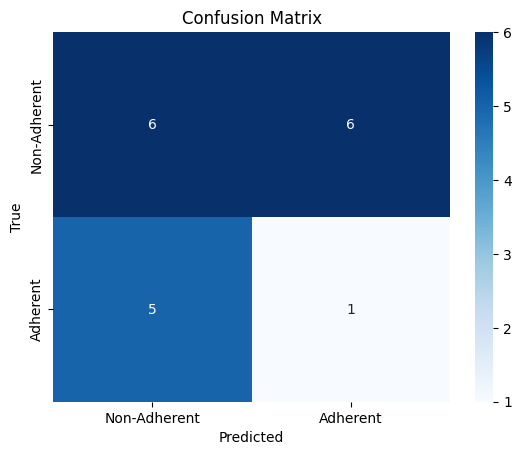

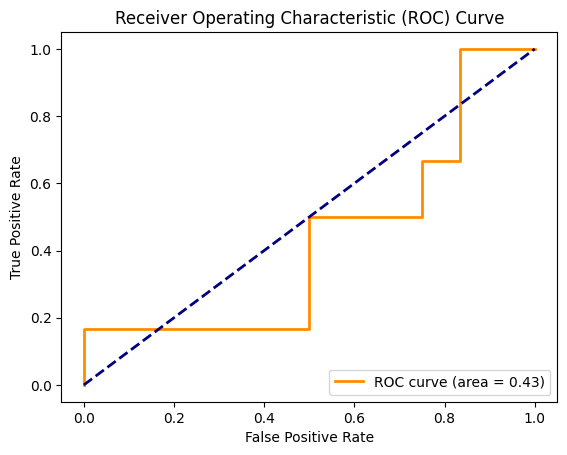

In [93]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Test evaluation
best_model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics for Best Model:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

# Calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    sparsity = zero_params / total_params
    return sparsity

sparsity = calculate_sparsity(best_model)
print(f"Sparsity of Best Model: {sparsity:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_true, test_preds_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Adherent", "Adherent"], yticklabels=["Non-Adherent", "Adherent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# MODEL 2: XGBOOST

## Implementation


Data Processing & SMOTE Application

In [118]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv("cleaned_mental_health_data.csv")

# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]
df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and labels
X = df.drop(columns="adherence").values
y = df["adherence"].values

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE to the training data to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_resampled)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_resampled))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


 Define Teacher Model

In [119]:
import torch.nn as nn

class TeacherModel(nn.Module):
    def __init__(self, input_dim):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize teacher model
teacher_model = TeacherModel(input_dim=X_train.shape[1])
teacher_model.to(device)  # Move to GPU if available


TeacherModel(
  (fc1): Linear(in_features=59, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Train the Teacher Model

In [120]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    teacher_model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = teacher_model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Save the trained teacher model
torch.save(teacher_model.state_dict(), "best_teacher.pth")


Epoch 1/10, Loss: 2.8178
Epoch 2/10, Loss: 2.6501
Epoch 3/10, Loss: 2.5464
Epoch 4/10, Loss: 2.3624
Epoch 5/10, Loss: 2.2547
Epoch 6/10, Loss: 2.1743
Epoch 7/10, Loss: 2.0328
Epoch 8/10, Loss: 1.8023
Epoch 9/10, Loss: 1.5875
Epoch 10/10, Loss: 1.4401


Evaluate the Teacher Model

In [121]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the Teacher Model on the validation set
teacher_model.eval()
val_preds, val_true = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = teacher_model(inputs).squeeze()
        val_preds.extend(outputs.cpu().numpy())
        val_true.extend(labels.cpu().numpy())

# Convert predictions to binary (0 or 1)
val_preds_binary = (np.array(val_preds) > 0.5).astype(int)

# Calculate metrics
val_precision = precision_score(val_true, val_preds_binary)
val_recall = recall_score(val_true, val_preds_binary)
val_f1 = f1_score(val_true, val_preds_binary)
val_auc = roc_auc_score(val_true, val_preds)

print("Teacher Model Evaluation (Validation Set):")
print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")
print(f"Val F1-Score: {val_f1:.4f} | Val AUC: {val_auc:.4f}")

# Evaluate the Teacher Model on the test set
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = teacher_model(inputs).squeeze()
        test_preds.extend(outputs.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_auc = roc_auc_score(test_true, test_preds)

print("Teacher Model Evaluation (Test Set):")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")


Teacher Model Evaluation (Validation Set):
Val Precision: 0.3333 | Val Recall: 0.1667
Val F1-Score: 0.2222 | Val AUC: 0.7361
Teacher Model Evaluation (Test Set):
Test Precision: 0.2500 | Test Recall: 0.1667
Test F1-Score: 0.2000 | Test AUC: 0.5000


Load Teacher Model and Define Student Model

In [122]:
# Load the trained teacher model
teacher_model = TeacherModel(input_dim=X_train.shape[1])
teacher_model.load_state_dict(torch.load("best_teacher.pth"))
teacher_model.eval()  # Set to evaluation mode
teacher_model.to(device)

# Define the Student Model
class StudentModel(nn.Module):
    def __init__(self, input_dim):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize student model
student_model = StudentModel(input_dim=X_train.shape[1])
student_model.to(device)


<ipython-input-122-202fad7a504f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("best_teacher.pth"))


StudentModel(
  (fc1): Linear(in_features=59, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Distillation Loss Function

In [130]:
import torch.nn.functional as F

def distillation_loss(student_preds, teacher_preds, labels, alpha=0.7, temperature=2.0):
    # BCE loss for the student's binary classification task
    loss_bce = nn.BCELoss()(student_preds.squeeze(), labels)  # Ensure predictions are squeezed to match label shape

    # Teacher's predictions should be detached for distillation loss
    teacher_preds = teacher_preds.detach()

    # Distillation loss (KL Divergence between the student and teacher predictions)
    distillation_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_preds / temperature, dim=0),
        F.softmax(teacher_preds / temperature, dim=0)
    )

    # Combined loss
    total_loss = alpha * loss_bce + (1 - alpha) * distillation_loss
    return total_loss


Train the Student Model with Distillation

In [131]:
# Load the best saved teacher model
teacher_model.load_state_dict(torch.load("best_teacher.pth"))
teacher_model.eval()  # Set teacher model to evaluation mode

# Training loop for student model
best_val_loss = float("inf")
for epoch in range(epochs):
    student_model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass for teacher and student models
        teacher_preds = teacher_model(inputs)
        student_preds = student_model(inputs)

        # Calculate distillation loss
        loss = distillation_loss(student_preds.squeeze(), teacher_preds.squeeze(), labels)

        # Zero gradients, backward pass and optimize
        optimizer_student.zero_grad()
        loss.backward()
        optimizer_student.step()

    # Validation loop
    student_model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            student_preds = student_model(inputs)
            teacher_preds = teacher_model(inputs)
            loss = distillation_loss(student_preds.squeeze(), teacher_preds.squeeze(), labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Student Validation Loss: {val_loss:.4f}")

    # Early stopping based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(student_model.state_dict(), "best_student.pth")


Epoch 1/10, Student Validation Loss: 0.5382
Epoch 2/10, Student Validation Loss: 0.5382
Epoch 3/10, Student Validation Loss: 0.5382
Epoch 4/10, Student Validation Loss: 0.5382
Epoch 5/10, Student Validation Loss: 0.5382
Epoch 6/10, Student Validation Loss: 0.5382
Epoch 7/10, Student Validation Loss: 0.5382
Epoch 8/10, Student Validation Loss: 0.5382
Epoch 9/10, Student Validation Loss: 0.5382
Epoch 10/10, Student Validation Loss: 0.5382


<ipython-input-131-1a506f72513f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("best_teacher.pth"))


evaluate student moel

In [136]:
# Load the best student model for evaluation
student_model.load_state_dict(torch.load("best_student.pth"))
student_model.eval()

# Initialize metrics for student model
test_preds_student, test_true = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs_student = student_model(inputs).squeeze()
        test_preds_student.extend(outputs_student.cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Convert predictions to binary (0 or 1)
test_preds_student_binary = (np.array(test_preds_student) > 0.3).astype(int)

# Calculate metrics for student model
test_precision_student = precision_score(test_true, test_preds_student_binary)
test_recall_student = recall_score(test_true, test_preds_student_binary)
test_f1_student = f1_score(test_true, test_preds_student_binary)
test_auc_student = roc_auc_score(test_true, test_preds_student)

print(f"Student Model Test Metrics:")
print(f"Test Precision: {test_precision_student:.4f} | Test Recall: {test_recall_student:.4f}")
print(f"Test F1-Score: {test_f1_student:.4f} | Test AUC: {test_auc_student:.4f}")


Student Model Test Metrics:
Test Precision: 0.3333 | Test Recall: 1.0000
Test F1-Score: 0.5000 | Test AUC: 0.7083


<ipython-input-136-e4c329839e03>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load("best_student.pth"))


# New section

##Implement the Feedforward Neural Network

1 Implementation

In [137]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the first model architecture (Feedforward Neural Network)
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 32)         # Second hidden layer
        self.fc3 = nn.Linear(32, 1)          # Output layer
        self.sigmoid = nn.Sigmoid()          # Sigmoid activation for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))           # ReLU activation
        x = torch.relu(self.fc2(x))           # ReLU activation
        x = self.sigmoid(self.fc3(x))         # Output layer with sigmoid activation
        return x

# Example input dimension (you should use the actual number of features)
input_dim = X_train.shape[1]  # assuming X_train is already defined
model = FeedForwardNN(input_dim)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()  # Binary Cross Entropy for binary classification

# Training loop
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)  # Squeeze to make outputs the same shape as labels
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted.squeeze() == labels).sum().item()
            total += labels.size(0)

        # Validation step
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += loss_fn(outputs.squeeze(), labels).item()

                predicted = (outputs > 0.5).float()
                val_correct += (predicted.squeeze() == labels).sum().item()
                val_total += labels.size(0)

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Save model if it's the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_feedforward_model.pth")

# Move the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
train_model(model, train_loader, val_loader, optimizer, loss_fn)


Epoch 1/100, Train Loss: 0.7077, Train Accuracy: 0.5000, Val Loss: 0.7428, Val Accuracy: 0.3333
Epoch 2/100, Train Loss: 0.6827, Train Accuracy: 0.5182, Val Loss: 0.7225, Val Accuracy: 0.5000
Epoch 3/100, Train Loss: 0.6629, Train Accuracy: 0.5818, Val Loss: 0.7050, Val Accuracy: 0.5000
Epoch 4/100, Train Loss: 0.6504, Train Accuracy: 0.6727, Val Loss: 0.6895, Val Accuracy: 0.6111
Epoch 5/100, Train Loss: 0.6287, Train Accuracy: 0.7727, Val Loss: 0.6730, Val Accuracy: 0.6667
Epoch 6/100, Train Loss: 0.6105, Train Accuracy: 0.8000, Val Loss: 0.6559, Val Accuracy: 0.6111
Epoch 7/100, Train Loss: 0.5879, Train Accuracy: 0.8364, Val Loss: 0.6373, Val Accuracy: 0.5556
Epoch 8/100, Train Loss: 0.5620, Train Accuracy: 0.8455, Val Loss: 0.6194, Val Accuracy: 0.5000
Epoch 9/100, Train Loss: 0.5321, Train Accuracy: 0.8727, Val Loss: 0.6034, Val Accuracy: 0.5000
Epoch 10/100, Train Loss: 0.5039, Train Accuracy: 0.8909, Val Loss: 0.5878, Val Accuracy: 0.5000
Epoch 11/100, Train Loss: 0.4685, Train

2. Prepare Data

In [139]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("cleaned_mental_health_data.csv")

# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]

df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Identify all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns to encode:", categorical_cols)

# Encode all categorical features
from sklearn.preprocessing import LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and labels
X = df.drop(columns="adherence").values
y = df["adherence"].values

# Split data into train, validation, test (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Apply SMOTE to only the training set
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check new class distribution
from collections import Counter
print("New class distribution:", Counter(y_train_resampled))

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Check the shape of the data to ensure it matches
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)

# Ensure that X_train_scaled and y_train_resampled have the same number of samples
assert X_train_scaled.shape[0] == y_train_resampled.shape[0], "Mismatch in number of samples between X_train_scaled and y_train_resampled"

# Convert to torch tensors
train_tensor = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32),
                              torch.tensor(y_train_resampled, dtype=torch.float32))
val_tensor = TensorDataset(torch.tensor(X_val_scaled, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.float32))
test_tensor = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=batch_size)
test_loader = DataLoader(test_tensor, batch_size=batch_size)


Categorical columns to encode: Index(['sex', 'Religion', 'marital status', 'education status', 'residence',
       'substance use', 'comorbidity',
       'It is unnatural for my mind and body to be controlled by medication?',
       'My thoughts are clearer on medication',
       'By staying on medication, I can prevent getting sick',
       'I feel weird, like a ‘zombie’ on medication',
       'Medication makes me feel tired and sluggish',
       'Some of your symptoms are made by your mind.', 'You are mentally well',
       'You do not need medication', 'Your stay in the hospital is necessary',
       'The doctor is right in prescribing medication for you.',
       'You do not need to be seen by a doctor or psychiatrist',
       'If someone said you have a nervous or mental illness, they would be right',
       'None of the unusual things you are experiencing are due to an illness.',
       '. Loss of energy or drive', 'Feeling unmotivated or numb',
       'Daytime sedation or drowsi

3 Model initialisation

In [140]:
# Initialize the FeedForwardNN model
input_dim = X_train.shape[1]  # number of features in your dataset
model = FeedForwardNN(input_dim)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification


4 TRaining the model

In [141]:
# Training the model
train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=100)


Epoch 1/100, Train Loss: 0.6876, Train Accuracy: 0.5818, Val Loss: 0.6774, Val Accuracy: 0.5556
Epoch 2/100, Train Loss: 0.6628, Train Accuracy: 0.7000, Val Loss: 0.6593, Val Accuracy: 0.5556
Epoch 3/100, Train Loss: 0.6476, Train Accuracy: 0.7727, Val Loss: 0.6403, Val Accuracy: 0.5556
Epoch 4/100, Train Loss: 0.6316, Train Accuracy: 0.7818, Val Loss: 0.6214, Val Accuracy: 0.6111
Epoch 5/100, Train Loss: 0.6092, Train Accuracy: 0.8182, Val Loss: 0.6022, Val Accuracy: 0.6667
Epoch 6/100, Train Loss: 0.5837, Train Accuracy: 0.8545, Val Loss: 0.5828, Val Accuracy: 0.6667
Epoch 7/100, Train Loss: 0.5746, Train Accuracy: 0.8545, Val Loss: 0.5662, Val Accuracy: 0.6667
Epoch 8/100, Train Loss: 0.5603, Train Accuracy: 0.8909, Val Loss: 0.5529, Val Accuracy: 0.6667
Epoch 9/100, Train Loss: 0.5318, Train Accuracy: 0.8818, Val Loss: 0.5427, Val Accuracy: 0.6667
Epoch 10/100, Train Loss: 0.5092, Train Accuracy: 0.9091, Val Loss: 0.5372, Val Accuracy: 0.6667
Epoch 11/100, Train Loss: 0.4702, Train

5 Evaluation

In [144]:
import time
import torch
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Define your model (for example, using a simple neural network)
class SimpleNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, optimizer, and loss function
input_dim = X_train_scaled.shape[1]
model = SimpleNN(input_dim)
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()

# Start tracking training time
start_time = time.time()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Evaluation on validation set after each epoch
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_preds.append(outputs.squeeze().cpu().numpy())
            val_labels.append(labels.cpu().numpy())

    val_preds = np.concatenate(val_preds)
    val_labels = np.concatenate(val_labels)

    # Calculate metrics
    val_precision = precision_score(val_labels, (val_preds > 0.5).astype(int))
    val_recall = recall_score(val_labels, (val_preds > 0.5).astype(int))
    val_f1 = f1_score(val_labels, (val_preds > 0.5).astype(int))
    val_auc = roc_auc_score(val_labels, val_preds)

    # Print metrics
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%")
    print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")

# End training time
end_time = time.time()
training_time = end_time - start_time

# Final evaluation on test set
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_preds.append(outputs.squeeze().cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# Calculate final test metrics
test_precision = precision_score(test_labels, (test_preds > 0.5).astype(int))
test_recall = recall_score(test_labels, (test_preds > 0.5).astype(int))
test_f1 = f1_score(test_labels, (test_preds > 0.5).astype(int))
test_auc = roc_auc_score(test_labels, test_preds)

# Print test metrics
print("\nTest Metrics:")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")

# Print learning rate and training time
print(f"\nLearning Rate: {learning_rate}")
print(f"Training Time: {training_time:.2f} seconds")


Epoch 1/10 | Loss: 0.6937 | Accuracy: 49.09%
Validation Precision: 0.3333 | Validation Recall: 1.0000
Validation F1-Score: 0.5000 | Validation AUC: 0.5694
Epoch 2/10 | Loss: 0.6743 | Accuracy: 60.91%
Validation Precision: 0.4167 | Validation Recall: 0.8333
Validation F1-Score: 0.5556 | Validation AUC: 0.6944
Epoch 3/10 | Loss: 0.6608 | Accuracy: 72.73%
Validation Precision: 0.5000 | Validation Recall: 0.8333
Validation F1-Score: 0.6250 | Validation AUC: 0.7500
Epoch 4/10 | Loss: 0.6394 | Accuracy: 75.45%
Validation Precision: 0.6250 | Validation Recall: 0.8333
Validation F1-Score: 0.7143 | Validation AUC: 0.6944
Epoch 5/10 | Loss: 0.6275 | Accuracy: 79.09%
Validation Precision: 0.4000 | Validation Recall: 0.3333
Validation F1-Score: 0.3636 | Validation AUC: 0.6806
Epoch 6/10 | Loss: 0.6048 | Accuracy: 81.82%
Validation Precision: 0.4000 | Validation Recall: 0.3333
Validation F1-Score: 0.3636 | Validation AUC: 0.6667
Epoch 7/10 | Loss: 0.5870 | Accuracy: 82.73%
Validation Precision: 0.4

Saving best model

In [143]:
# Load the best model for inference
best_model = FeedForwardNN(input_dim)
best_model.load_state_dict(torch.load("best_feedforward_model.pth"))
best_model.to(device)


<ipython-input-143-55df29be72a9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_feedforward_model.pth"))


FeedForwardNN(
  (fc1): Linear(in_features=59, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Implement Logisitic Regretion

1 Import Libraries

In [147]:
from sklearn.linear_model import LogisticRegression
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


2. Training

In [148]:
# Initialize the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

# Record the start time for training
start_time = time.time()

# Train the model
logreg_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time


3. Evaluation

In [149]:
# Predict on train, validation, and test sets
y_train_pred = logreg_model.predict(X_train_scaled)
y_val_pred = logreg_model.predict(X_val_scaled)
y_test_pred = logreg_model.predict(X_test_scaled)

# Calculate metrics for training, validation, and test sets
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_pred)

val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

# Print the metrics and training time
print(f"Training time: {training_time:.2f} seconds")
print(f"Training Precision: {train_precision:.4f} | Training Recall: {train_recall:.4f} | Training F1-Score: {train_f1:.4f} | Training AUC: {train_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f} | Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")


Training time: 0.07 seconds
Training Precision: 1.0000 | Training Recall: 1.0000 | Training F1-Score: 1.0000 | Training AUC: 1.0000
Validation Precision: 1.0000 | Validation Recall: 0.5000 | Validation F1-Score: 0.6667 | Validation AUC: 0.7500
Test Precision: 0.2500 | Test Recall: 0.1667 | Test F1-Score: 0.2000 | Test AUC: 0.4583


## Implementing Support Vector Machine

In [150]:
from sklearn.svm import SVC
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Initialize the SVM model with a radial basis function kernel
svm_model = SVC(probability=True, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time


Evaluation

In [151]:
# Predict on train, validation, and test sets
y_train_pred = svm_model.predict(X_train_scaled)
y_val_pred = svm_model.predict(X_val_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# Calculate metrics for training, validation, and test sets
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, svm_model.predict_proba(X_train_scaled)[:, 1])

val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, svm_model.predict_proba(X_val_scaled)[:, 1])

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, svm_model.predict_proba(X_test_scaled)[:, 1])

# Print the metrics and training time
print(f"Training time: {training_time:.2f} seconds")
print(f"Training Precision: {train_precision:.4f} | Training Recall: {train_recall:.4f} | Training F1-Score: {train_f1:.4f} | Training AUC: {train_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f} | Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")


Training time: 0.01 seconds
Training Precision: 1.0000 | Training Recall: 0.7308 | Training F1-Score: 0.8444 | Training AUC: 1.0000
Validation Precision: 1.0000 | Validation Recall: 0.1667 | Validation F1-Score: 0.2857 | Validation AUC: 0.6389
Test Precision: 0.0000 | Test Recall: 0.0000 | Test F1-Score: 0.0000 | Test AUC: 0.4167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Implementing Random Forest Classifier

In [152]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming data preprocessing has been done and the data is available in these variables
# X_train, X_val, X_test, y_train, y_val, y_test
# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#TRAINING

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

#EVALUATION

# Predict on train, validation, and test sets
y_train_pred = rf_model.predict(X_train_scaled)
y_val_pred = rf_model.predict(X_val_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate metrics for training, validation, and test sets
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, rf_model.predict_proba(X_train_scaled)[:, 1])

val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, rf_model.predict_proba(X_val_scaled)[:, 1])

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

# Print the metrics and training time
print(f"Training time: {training_time:.2f} seconds")
print(f"Training Precision: {train_precision:.4f} | Training Recall: {train_recall:.4f} | Training F1-Score: {train_f1:.4f} | Training AUC: {train_auc:.4f}")
print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f} | Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f} | Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")


Training time: 0.15 seconds
Training Precision: 1.0000 | Training Recall: 1.0000 | Training F1-Score: 1.0000 | Training AUC: 1.0000
Validation Precision: 0.7500 | Validation Recall: 0.5000 | Validation F1-Score: 0.6000 | Validation AUC: 0.7917
Test Precision: 1.0000 | Test Recall: 0.1667 | Test F1-Score: 0.2857 | Test AUC: 0.4653


## Implementing a K-Nearest Neighbor

In [153]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import time

# Initialize KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Record the start time for training
start_time = time.time()

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Make predictions on the test set
y_pred_knn = knn_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_knn)
report = classification_report(y_test, y_pred_knn)

# Store the metrics
print("KNN Model Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Training Time: {training_time:.4f} seconds")
print("Classification Report:\n", report)

# Optionally, return metrics if you plan to store them
metrics = {
    "model": "KNN",
    "accuracy": accuracy,
    "training_time": training_time,
    "classification_report": report
}


KNN Model Test Metrics:
Accuracy: 0.7222
Training Time: 0.0052 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.67      0.33      0.44         6

    accuracy                           0.72        18
   macro avg       0.70      0.62      0.63        18
weighted avg       0.71      0.72      0.69        18



Implementing Gradient Boost machine

In [154]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
gbm_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on the validation and test sets
y_val_pred = gbm_model.predict(X_val_scaled)
y_test_pred = gbm_model.predict(X_test_scaled)

# Calculate metrics for evaluation
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, gbm_model.predict_proba(X_val_scaled)[:, 1])

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, gbm_model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f"Gradient Boosting Model Evaluation (Validation Set):")
print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f}")
print(f"Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")

print(f"\nGradient Boosting Model Evaluation (Test Set):")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")

print(f"\nTraining Time: {training_time:.4f} seconds")


Gradient Boosting Model Evaluation (Validation Set):
Validation Precision: 0.5000 | Validation Recall: 0.5000
Validation F1-Score: 0.5000 | Validation AUC: 0.6389

Gradient Boosting Model Evaluation (Test Set):
Test Precision: 0.3333 | Test Recall: 0.3333
Test F1-Score: 0.3333 | Test AUC: 0.4444

Training Time: 0.2934 seconds


## Implementing XGBoost

In [155]:
!pip install xgboost


In [156]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import time

# Initialize XGBoost Classifier
xgboost_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Record the start time for training
start_time = time.time()

# Train the model
xgboost_model.fit(X_train_scaled, y_train)

# Record the end time for training
end_time = time.time()
training_time = end_time - start_time

# Predict on the validation and test sets
y_val_pred = xgboost_model.predict(X_val_scaled)
y_test_pred = xgboost_model.predict(X_test_scaled)

# Calculate metrics for evaluation
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, xgboost_model.predict_proba(X_val_scaled)[:, 1])

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, xgboost_model.predict_proba(X_test_scaled)[:, 1])

# Print the evaluation metrics
print(f"XGBoost Model Evaluation (Validation Set):")
print(f"Validation Precision: {val_precision:.4f} | Validation Recall: {val_recall:.4f}")
print(f"Validation F1-Score: {val_f1:.4f} | Validation AUC: {val_auc:.4f}")

print(f"\nXGBoost Model Evaluation (Test Set):")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test AUC: {test_auc:.4f}")

print(f"\nTraining Time: {training_time:.4f} seconds")


XGBoost Model Evaluation (Validation Set):
Validation Precision: 0.6000 | Validation Recall: 0.5000
Validation F1-Score: 0.5455 | Validation AUC: 0.5556

XGBoost Model Evaluation (Test Set):
Test Precision: 0.2000 | Test Recall: 0.1667
Test F1-Score: 0.1818 | Test AUC: 0.3750

Training Time: 0.0725 seconds


## Implementing